In [32]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy import stats

import brian2hears as bh
from brian2.units import kHz

from analyses_helper import calc_smi

import importlib

import analyses_helper
importlib.reload(analyses_helper)
from analyses_helper import *

import warnings
warnings.filterwarnings('ignore')

In [6]:
# read in data and print out parameter combinations 
data = pd.read_pickle(r'../data/model_results/nmda_ampa_alpha.pkl')
data[["NMDA_WEIGHT", "AMPA_WEIGHT", "GABA_WEIGHT"]] = data[["NMDA_WEIGHT", "AMPA_WEIGHT", "GABA_WEIGHT"]].apply(pd.to_numeric)
data[["AMPA_WEIGHT", "NMDA_WEIGHT", "GABA_WEIGHT", "DELAY"]] = data[["AMPA_WEIGHT", "NMDA_WEIGHT", "GABA_WEIGHT", "DELAY"]].astype(float)
data.groupby(["NMDA_WEIGHT", "AMPA_WEIGHT", "GABA_WEIGHT", "ALPHA"]).apply(lambda x: np.max(x['ITER']))

NMDA_WEIGHT  AMPA_WEIGHT  GABA_WEIGHT  ALPHA
0.00         0.5          0.00         0.2      9
                                       0.4      9
                                       0.6      9
                                       0.8      9
                                       1.0      9
                          0.01         1.0      9
                          0.03         1.0      9
                          0.05         1.0      9
0.05         0.5          0.00         1.0      9
                          0.01         1.0      9
                          0.03         1.0      9
                          0.05         1.0      9
dtype: object

In [14]:
# calculate smi distributions 
smis = data.groupby(['AMPA_WEIGHT', 'NMDA_WEIGHT', 'GABA_WEIGHT', 'ALPHA', 'clipA', 'clipB', 'DELAY']).apply(lambda x: calc_smi(x)).reset_index()
smi_vals = pd.DataFrame(smis[0].tolist(), columns=['ra', 'rb', 'rab', 'smi'])
smis = smis.join(smi_vals)

max_smi = smis.groupby(['AMPA_WEIGHT', 'NMDA_WEIGHT', 'GABA_WEIGHT', 'ALPHA', 'clipA', 'clipB']).apply(lambda x: calc_max_smi(x)).reset_index()
max_vals = pd.DataFrame(max_smi[0].tolist(), columns=['smi', 'DELAY'])
max_smi = max_smi.join(max_vals)

/home/gwa18/auditory/code/dendritic_integration/analyses/analyses_helper.py:39: RuntimeWarning: divide by zero encountered in scalar divide
/home/gwa18/auditory/code/dendritic_integration/analyses/analyses_helper.py:39: RuntimeWarning: invalid value encountered in scalar divide


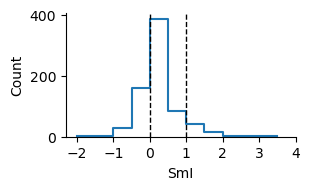

In [30]:
# figure 4a
ampa_only = smis[(smis['ALPHA']=="1.0") & 
                 (smis['NMDA_WEIGHT']==0.0) &
                 (smis['GABA_WEIGHT']==0.0)]

upper = np.ma.masked_invalid(ampa_only['smi'].values).max()
ampa_clip = ampa_only
ampa_clip.loc[ampa_only['smi'] == np.inf, 'smi'] = upper + 1 

plot_hist(ampa_clip, (3.2, 2))
#plt.savefig("./figs/ampa05.pdf", transparent=True, dpi=500)

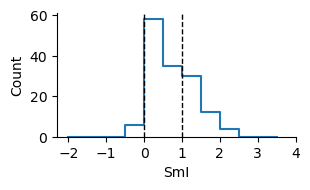

In [27]:
# figure 4b
ampa_max = max_smi[(max_smi['ALPHA']=="1.0") & 
                 (max_smi['NMDA_WEIGHT']==0.0) &
                 (max_smi['GABA_WEIGHT']==0.0)]

plot_hist(ampa_max, (3.2, 2))

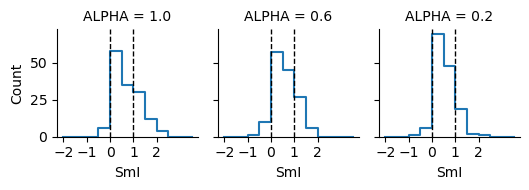

In [20]:
# figure 4c 
alpha_max = max_smi[(max_smi['GABA_WEIGHT']==0.0) & 
                    (max_smi['NMDA_WEIGHT']==0.0)]

alpha_max_sub = alpha_max[(alpha_max['ALPHA']=="1.0") |
                          (alpha_max['ALPHA']=="0.6") |
                          (alpha_max['ALPHA']=="0.2")]

alpha_max_sub['ALPHA'] = alpha_max_sub['ALPHA'].astype('category')
alpha_max_sub['ALPHA'] = alpha_max_sub['ALPHA'].cat.reorder_categories(["1.0", "0.6", "0.2"])

g = sns.FacetGrid(data=alpha_max_sub, col="ALPHA", height=2, aspect=0.9)
g.map(sns.histplot, "smi", bins=np.arange(-2, 4, 0.5), element="step", fill=None)
g.refline(x=0, linestyle='--', color='k', linewidth=1.0)
g.refline(x=1, linestyle='--', color='k', linewidth=1.0)
g.set(xticks=np.arange(-2, 2.5, 1))
g.set(xlabel="SmI")
#plt.savefig("./figs/alpha.pdf", transparent=True, dpi=500)

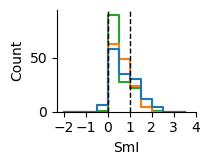

In [34]:
# figure 4d 
sns.reset_defaults()
nmda_smi = max_smi[(max_smi['NMDA_WEIGHT']==0.05) &
                   (max_smi['GABA_WEIGHT']!=0.01) &
                   (max_smi['GABA_WEIGHT']!=0.05)] 
nmda_smi['params'] = max_smi['NMDA_WEIGHT'] + max_smi['GABA_WEIGHT']

ampa_only = max_smi[(max_smi['NMDA_WEIGHT']==0.0) & (max_smi['ALPHA']=="1.0") & (max_smi['GABA_WEIGHT']==0)]
ampa_only['params'] = 0

nmda_ampa = pd.concat([ampa_only, nmda_smi], ignore_index=True)
nmda_ampa['params'] = nmda_ampa['params'].astype('category')

plot_hist(nmda_ampa, (2.2, 1.75))

In [38]:
# overlap between dendritic profiles 
dist = pd.read_pickle(r"../data/model_results/dendrites_ampa.pkl")
dist2 = dist[["clipA", "clipB", "DELAY"]]
dist2['tcorr'] = np.nan
dist2['scorr'] = np.nan

for index, row in dist.iterrows():
    d1 = pd.DataFrame(row['A']).to_numpy().T
    d2 = pd.DataFrame(row['B']).to_numpy().T

    d1_t = np.nansum(d1, axis=0)
    d2_t = np.nansum(d2, axis=0)

    d1_s = np.nansum(d1, axis=1)
    d2_s = np.nansum(d2, axis=1)

    dist2.loc[index, 'tcorr'] = np.corrcoef(d1_t, d2_t)[0, 1]
    dist2.loc[index, 'scorr'] = np.corrcoef(d1_s, d2_s)[0, 1]

dist2['DELAY'] = pd.to_numeric(dist2['DELAY'])

new_df = ampa_max.merge(dist2, how="left", on=['clipA', 'clipB', 'DELAY'])
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.dropna(inplace=True)

a1 = new_df[(new_df['tcorr'] > 0.3) & (new_df['scorr'] < 0.1)]
a1['labs'] = "dis_cor"
a2 = new_df[(new_df['tcorr'] < 0.3) & (new_df['scorr'] > 0.1)]
a2['labs'] = "clu_un"

compare = pd.concat([a1, a2])

stats.kruskal(a1['smi'].values, a2['smi'].values)


#fig, ax = plt.subplots(figsize=(2, 2))
#sns.boxplot(data=compare, x="labs", y="smi", color="black", fill=False, showfliers=False, ax=ax)
#sns.stripplot(data=compare, x="labs", y="smi", color="gray", alpha=0.8,  marker="$\circ$", ax=ax)
#sns.despine()
#plt.tight_layout()
#plt.savefig("./figs/boxplot.pdf", transparent=True, dpi=500)

KruskalResult(statistic=224.6489304375093, pvalue=8.757503070391349e-51)